## Importing Libraries and load Data

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os

In [121]:
# os.listdir()
data = pd.read_excel('TrainDataset2023.xls')
cols = data.columns.values

# Checking for improper column names
bad_names = [name for name in cols if re.findall(r"\W",name)]
repaired_names = [re.sub(r'\s|\(.+\)','',name) for name in cols]


# Rename columns
data.columns = repaired_names
data.columns


Index(['ID', 'pCR', 'RelapseFreeSurvival', 'Age', 'ER', 'PgR', 'HER2',
       'TrippleNegative', 'ChemoGrade', 'Proliferation',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=120)

# Data processing

In [122]:
# Checking for missing values
# Missing values are coded as 999

for col in data.columns:
    data[col].replace(999,np.nan, inplace=True)

In [123]:
def check_missing(df):
    missing = df.isna().sum()
    missing = missing[missing>0]
    missing.sort_values(ascending=False,inplace=True)
    # print(missing)
    return(missing)

check_missing(data)

pCR                5
ChemoGrade         3
HistologyType      3
Proliferation      2
PgR                1
HER2               1
TrippleNegative    1
LNStatus           1
dtype: int64

In [124]:
# Since the target is outcome of treatment, imputing this variable may not be safe, therefore dropped from the dataset
# missing values in features can be imputed
data = data.loc[~data['pCR'].isna(),:]

# again check for missing values
check_missing(data)

ChemoGrade         3
HistologyType      3
Proliferation      2
PgR                1
HER2               1
TrippleNegative    1
LNStatus           1
dtype: int64

In [130]:
#drop ID column
data.drop('ID',axis=1,inplace=True)
data.columns

Index(['pCR', 'RelapseFreeSurvival', 'Age', 'ER', 'PgR', 'HER2',
       'TrippleNegative', 'ChemoGrade', 'Proliferation', 'HistologyType',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=119)

In [131]:
## Split the dataset into training and test sets, before pre-processing to avoid data leakage
from sklearn.model_selection import train_test_split

# X = data.loc[:,~data.columns.isin(['ID','pCR','RelapseFreeSurvival'])]
# y = data.loc[:,['pCR','RelapseFreeSurvival']]

data_train, data_test = train_test_split(data,test_size=.15,shuffle=True,stratify=data['pCR'])


print(data_train.index)


Index([ 49, 213,  30, 269,  69, 296,  56, 380, 202, 289,
       ...
       190,  12,   3,  15, 105, 230,  81, 348, 250, 326],
      dtype='int64', length=335)


In [132]:
# check distribution of data by pCR
p_train = data_train['pCR'].value_counts()/sum(data_train['pCR'].value_counts())
p_test = data_test['pCR'].value_counts()/sum(data_test['pCR'].value_counts())

print(p_train)
print(data_train.shape)
print(p_test)
print(data_test.shape)

pCR
0.0    0.78806
1.0    0.21194
Name: count, dtype: float64
(335, 119)
pCR
0.0    0.783333
1.0    0.216667
Name: count, dtype: float64
(60, 119)


## Imputing missing values
- KNN imputer is preferred since it imputes values based on closely similar datapoints
- One neigbor is used for imputation, this avoids meaningless imputation for categorical features
- To avoid data leakage, a test set is reserved before any data preprocessing
- This will be used to evaluate the models after training is completed

In [133]:
# replace missing values by imputation, 
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)


tmp = imputer.fit_transform(data_train)
imputer.feature_names_in_
imputer.n_features_in_

data_train_imp = pd.DataFrame(tmp,columns=imputer.get_feature_names_out())
# X_train.head()

print(data_train_imp.shape)

# check missing
check_missing(data_train_imp)

(335, 119)


Series([], dtype: int64)

In [134]:
# Join X, y for training data for desription and plotting
print(data_train.shape)

# df = pd.merge(data_train,X_train_imp,left_index=True,right_index=True,how='inner',indicator=True)
# df['_merge']
# # pd.Index(X_train_imp.index)
# y_train.index
# df.describe()

(335, 119)


In [135]:
data_train.describe()

,pCR,RelapseFreeSurvival,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000,332.000000,333.000000,332.000000,...,3.350000e+02,3.350000e+02,3.350000e+02,335.000000,3.350000e+02,335.000000,335.000000,335.000000,335.000000,335.000000
mean,0.211940,55.722886,51.932152,0.558209,0.411940,0.298507,0.325373,2.388554,1.567568,1.156627,...,3.895160e-01,3.840981e-01,2.723161e+00,0.003259,6.532956e+07,190.718644,35820.927713,0.058748,0.006334,0.029091
std,0.409294,27.036984,11.189991,0.497343,0.492921,0.458288,0.469215,0.500382,0.763887,0.363997,...,1.710021e-01,1.650067e-01,7.766630e-01,0.002414,7.716624e+08,1140.046222,186121.366633,0.048513,0.008798,0.122292
min,0.000000,5.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.425736,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,...,3.145717e-01,3.141102e-01,2.321928e+00,0.001290,1.119281e+06,21.894569,0.001833,0.019310,0.000354,0.001470
50%,0.000000,54.500000,51.542779,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,...,4.038595e-01,4.000000e-01,2.821476e+00,0.002811,3.407536e+06,68.117000,0.004358,0.048077,0.002599,0.003180
75%,0.000000,73.000000,60.366290,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,...,4.981774e-01,4.915655e-01,3.313636e+00,0.004638,9.415701e+06,158.412059,0.012290,0.088521,0.008579,0.008746
max,1.000000,144.000000,79.603012,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,2.000000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


In [136]:
data_train_imp.iloc[:,0:15].dtypes

pCR                               float64
RelapseFreeSurvival               float64
Age                               float64
ER                                float64
PgR                               float64
HER2                              float64
TrippleNegative                   float64
ChemoGrade                        float64
Proliferation                     float64
HistologyType                     float64
LNStatus                          float64
TumourStage                       float64
original_shape_Elongation         float64
original_shape_Flatness           float64
original_shape_LeastAxisLength    float64
dtype: object

In [ ]:
# Correct 

In [137]:
# Counts for targest and categorical features

#list_cat = ['pCR', 'TumourStage', 'ER']
cols = list(data_train_imp.columns.values)
list_cat =cols[cols.index('ER') :cols.index('TumourStage')]
list_cat.insert(0,'pCR')

for v in list_cat:
    print(data_train_imp[v].value_counts())

#data['pCR'].value_counts()

pCR
0.0    264
1.0     71
Name: count, dtype: int64
ER
1.0    187
0.0    148
Name: count, dtype: int64
PgR
0.0    197
1.0    138
Name: count, dtype: int64
HER2
0.0    235
1.0    100
Name: count, dtype: int64
TrippleNegative
0.0    226
1.0    109
Name: count, dtype: int64
ChemoGrade
2.0    200
3.0    133
1.0      2
Name: count, dtype: int64
Proliferation
1.0    201
2.0     78
3.0     56
Name: count, dtype: int64
HistologyType
1.0    282
2.0     53
Name: count, dtype: int64
LNStatus
1.0    183
0.0    152
Name: count, dtype: int64


In [138]:
# change ER to str for hist plot
data_cat = data_train_imp[list_cat]
data_types =  data_cat.dtypes

for feature in list_cat:
    if data_cat[feature].dtype!=object:
        data_cat.loc[:,feature] = data_cat[feature].astype(str)
    


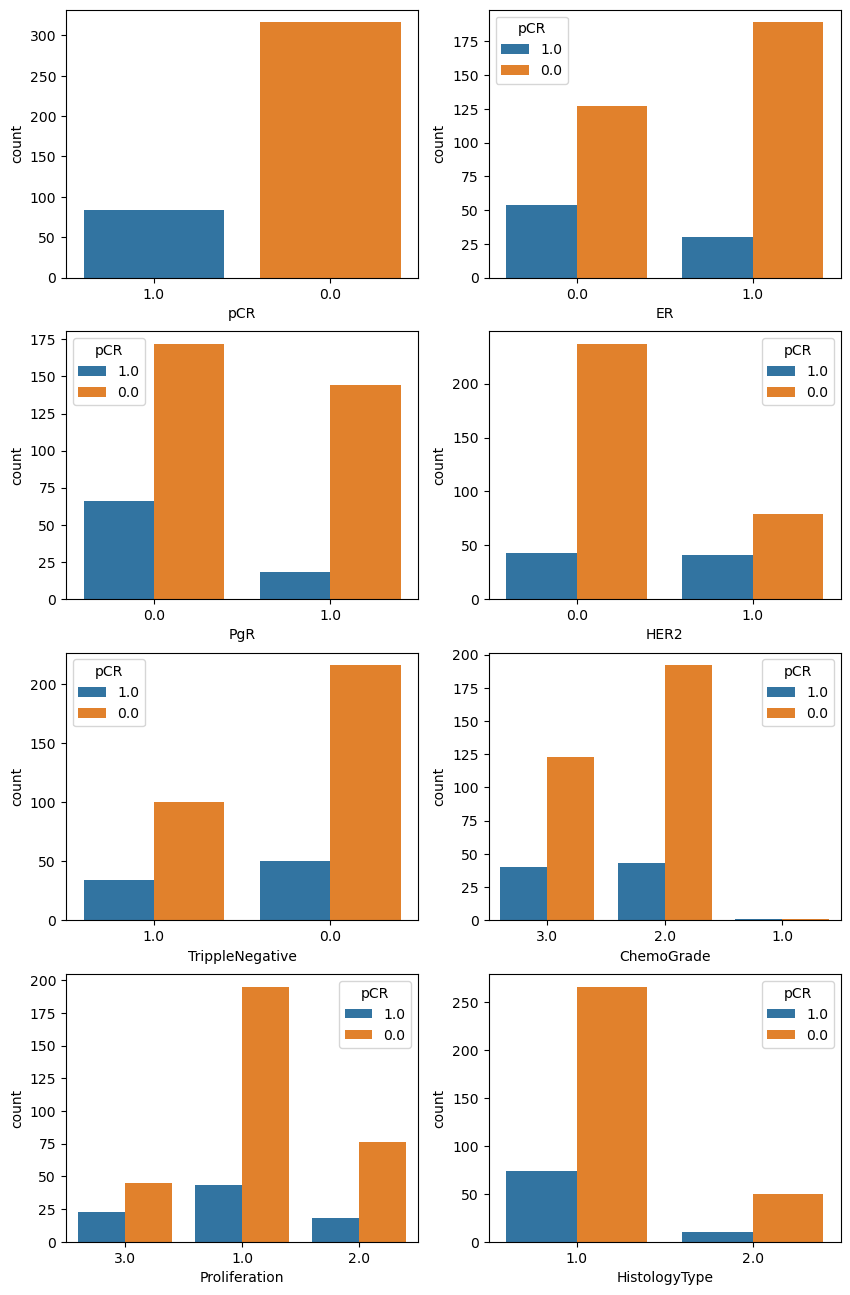

In [ ]:

fig, axs = plt.subplots(4,2,figsize=(10,16))
for ax, series in zip(axs.ravel(),data_cat):
    sns.countplot(x=series,ax=ax, data=data_cat,hue='pCR')
# axs[0,0].set_title('ER')


## visualizing Continuous data
- so many features have outliers, rescaling during training is required, also features significantly differ in scale

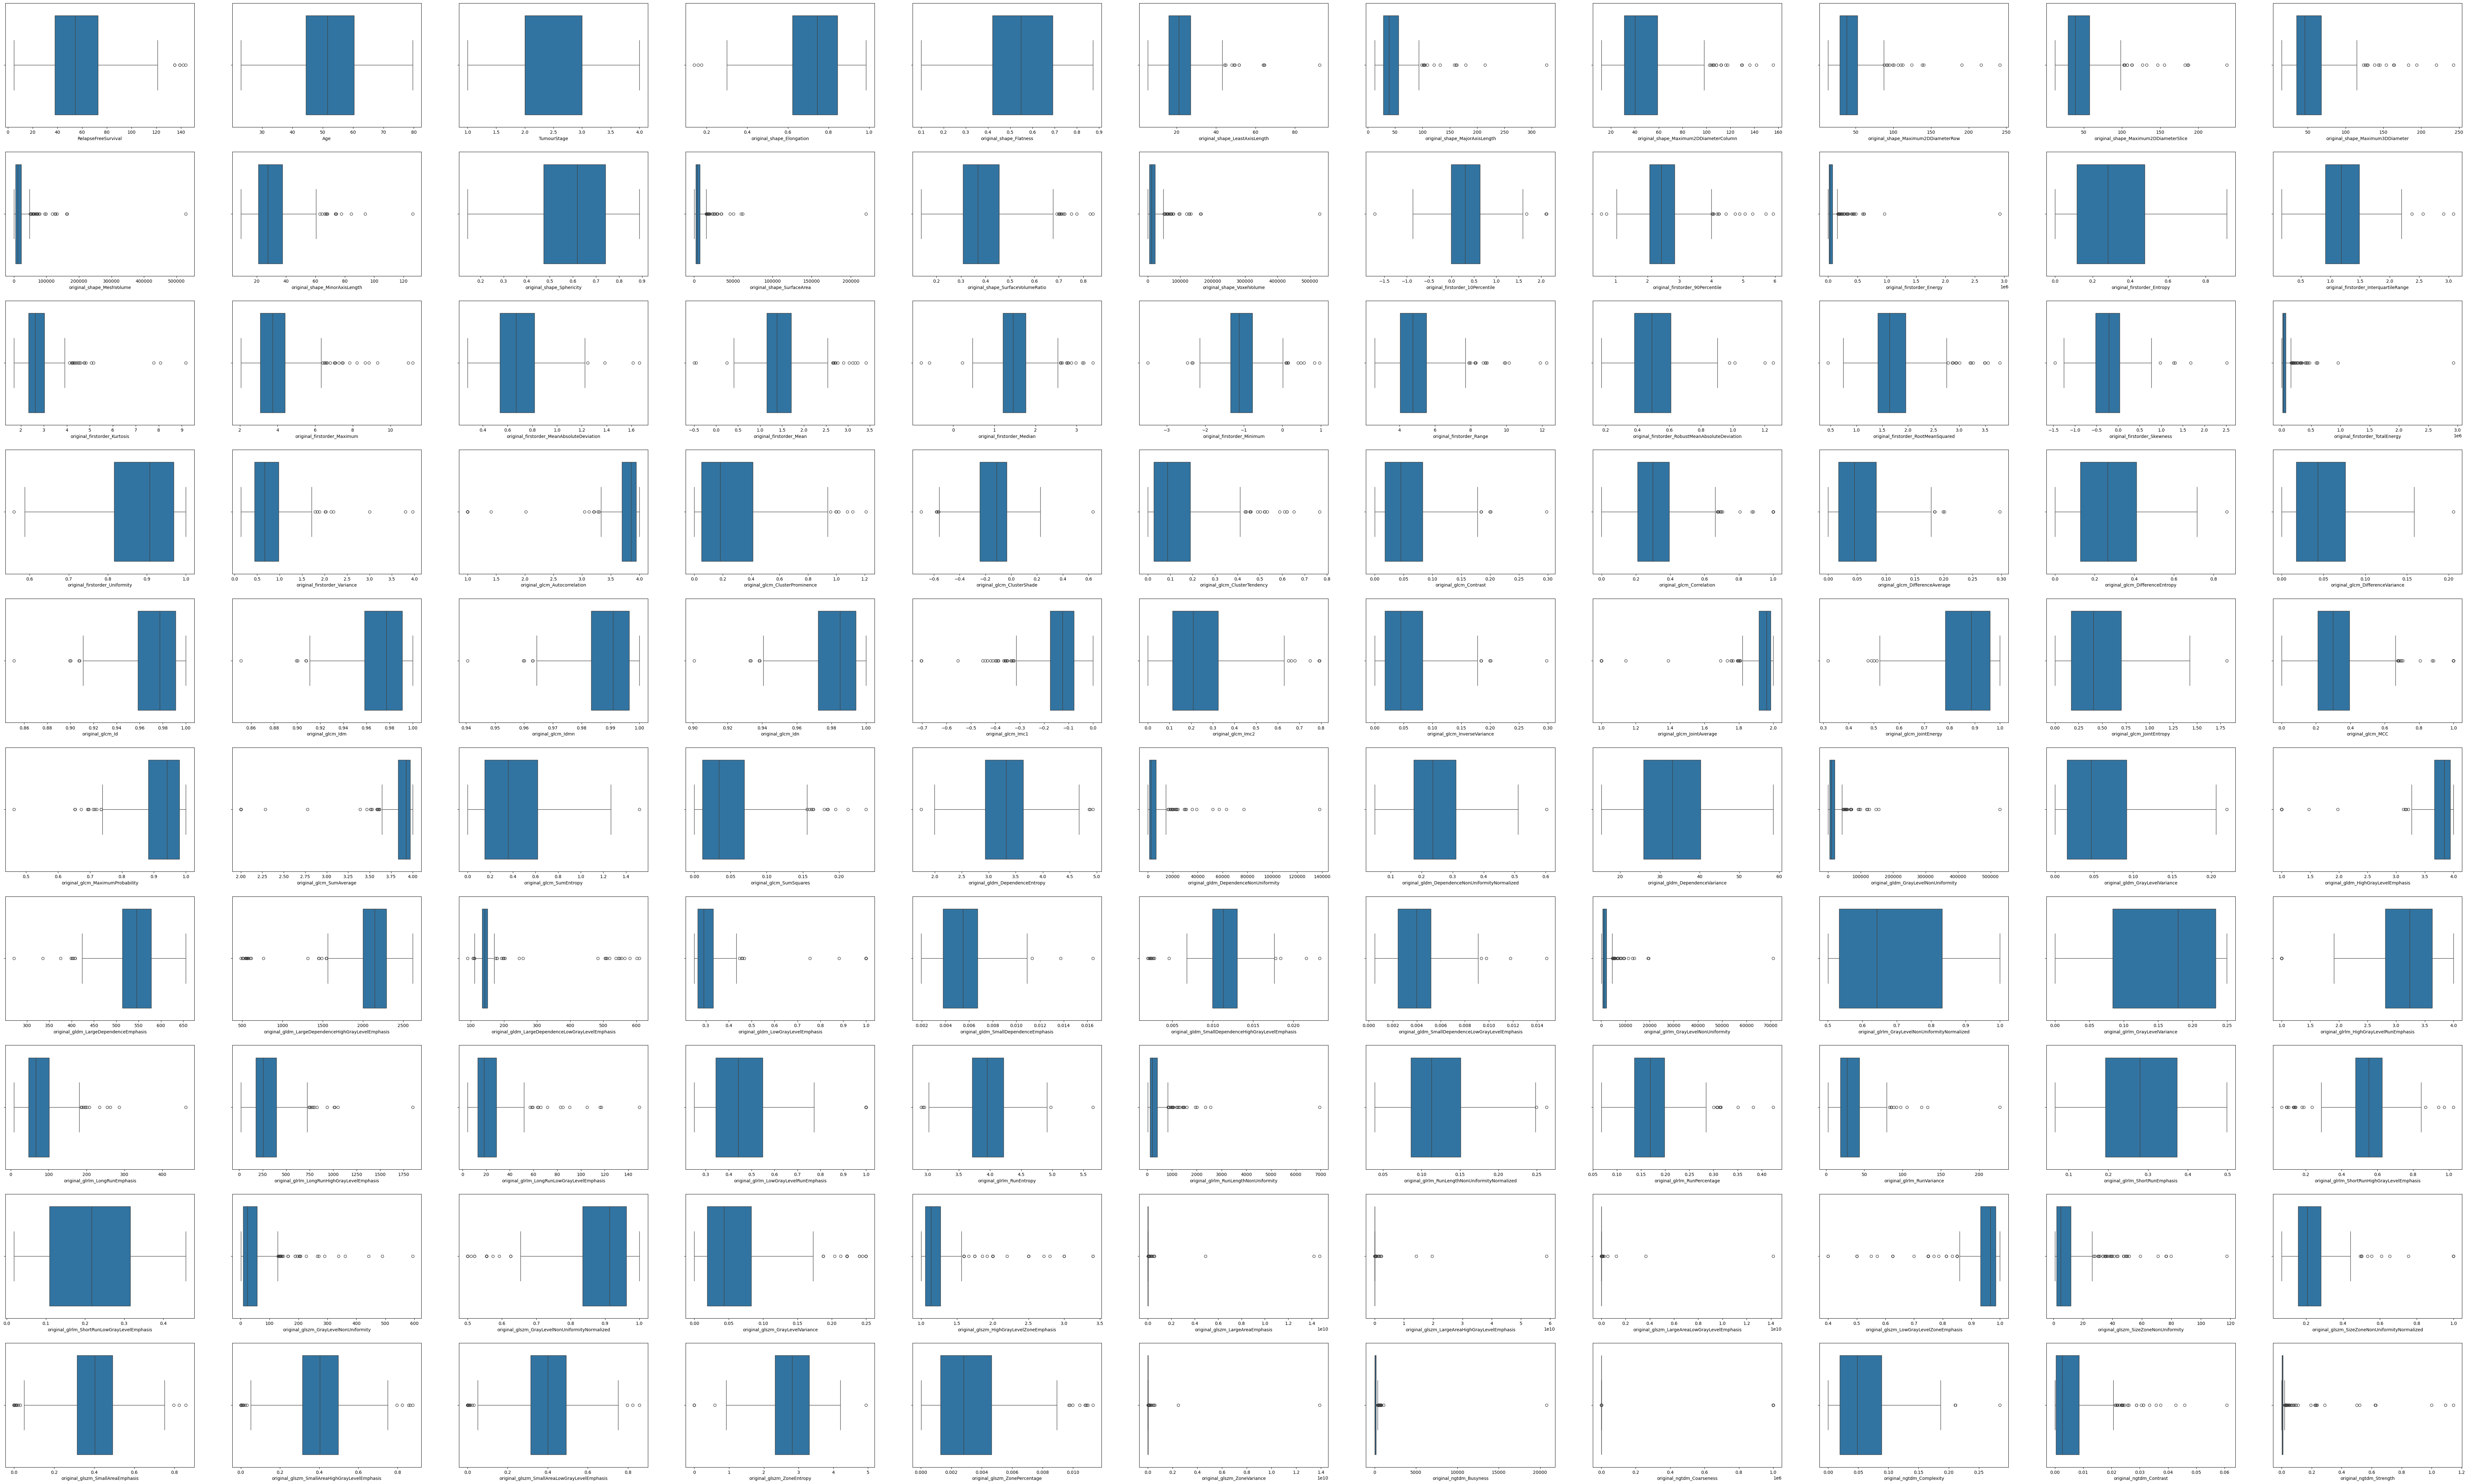

In [156]:
list_cont = [i for i in data_train_imp.columns.values if i not in list_cat]
data_cont = data_train_imp.loc[:,list_cont]


fig, axs = plt.subplots(10,11,figsize=(100,60))
for ax, series in zip(axs.ravel(),data_cont):
    sns.boxplot(x=series,ax=ax, data=data_cont)




In [154]:
## Correlation analysis

110